[![Open In Colab](https://img.shields.io/static/v1?message=Open%20in%20Colab&logo=googlecolab&label=%20&labelColor=5c5c5c&color=23c7a2&style=flat-square)](https://colab.research.google.com/github/einbandi/paradime/blob/master/notebooks/umap.ipynb)

Parametric UMAP
===============

In this example, we will set up a paraDime routine that is equivalent to a parametric implementation of UMAP. We will make use of the most important building blocks and methods of a [ParametricDR](../api/modules.rst#paradime.dr.ParametricDR) routine. The predefined [ParametricUMAP](../api/modules.rst#paradime.routines.ParametricUMAP) routine is defined in a similar way.

We start with some imports and define our dataset (MNIST handwritten image data):

In [2]:
from sklearn import manifold
import torch
import torchvision

from paradime import dr as pddr
from paradime import relations as pdrel
from paradime import transforms as pdtf
from paradime import loss as pdloss
from paradime import utils as pdutils

mnist = torchvision.datasets.MNIST(
    '../data',
    train=True,
    download=True,
)
mnist_data = mnist.data.reshape(-1, 28*28) / 255.
num_items = 5000

Relations
---------

Next, we define the global relations. UMAP uses the pairiwse distances between eavh data point and its `n`  nearest neighbors. The number of nearest neighbors `n` is a hyperparameter set by the user. The nearest neighbors are approximated using a tree-based algorithm. In paraDime, these approximate nearest neighbor relations are implemented as [NeighborBasedPDist](../api/modules.rst#paradime.relations.NeighborBasedPDist). UMAP then rescales the distances based on a Gaussian kernel, with kernel widths calculated for each data point by summed comparing kernel values to the binary logarithm of `n`. In paraDime, this transform is called [ConnectivityBasedRescale](../api/modules.rst#paradime.transforms.ConnectivityBasedRescale). Both the [NeighborBasedPDist](../api/modules.rst#paradime.relations.NeighborBasedPDist) relations and the [ConnectivityBasedRescale](../api/modules.rst#paradime.transforms.ConnectivityBasedRescale) transform take an `n_neighbors` parameter, but if the tranform is used inside the relations, the enclosing relations will automatically use the same values, so we only have to specify `n` once. In this example, we fix `n` to 30:

In [3]:
global_rel = pdrel.NeighborBasedPDist(
    transform=[
        pdtf.ConnectivityBasedRescale(n_neighbors=30),
        pdtf.Symmetrize(subtract_product=True),
    ]
)

Note that we also added a [Symmetrize](../api/modules.rst#paradime.transforms.Symmetrize) transform. The `subtract_product` option makes sure that the correct symmetrization for UMAP is used.

Now we define the batch-wise relations. Here, it iso important to understand that UMAP uses negative-edge sampling. This means, that the batch sampler (which we will specify later in on of the training phases) basically returns a list of pairs of indices of data points, which can be used to calculate the distances along the *edges* between those data points. (In contrast, regular sampling just returns a batch of item indices and assumes that all pairwise distances will be calculated.)
At the moment, the only relations compatible with negative edge sampling in paraDime are [DistsFromTo](../api/modules.rst#paradime.relations.DistsFromTo), which we use here:

In [4]:
batch_rel = pdrel.DistsFromTo(
    transform=[
        pdtf.ModifiedCauchyTransform(
            min_dist=0.1,
            spread=1,
        )
    ]
)

You can see that we transform the distances with a [ModifiedCauchyTransform](../api/modules.rst#paradime.transforms.ModifiedCauchyTransform), which applies a slightly modified Cauchy distribution to the distances. The exact modification is controlled through the UMAP hyperparameters `min_dist` and `spread`.

Losses and Derived Data
-----------------------

MAP embeddings are initialized with a spectral embedding based on the computed relations between the data points. The usual way to perform an initialization step in paraDime is to set up an extra training phase in which the model is trained to embed the data in such a way that the embedding coordinates match a set of given positions. In UMAP, the positions used for initialization require the computed relations. ParaDime provides a way to set up derived data, based either on other data entries or global relations. Let's first define our function that computes the spectral embedding from the relations:

In [5]:
def spectral(rels, out_dim=2):
    emb = manifold.SpectralEmbedding(
        affinity='precomputed',
        n_components=out_dim,
    ).fit_transform(rels.to_square_array().data)

    emb = (emb - emb.mean(axis=0)) / emb.std(axis=0)

    return emb

We simply used scikit-learn's [SpectralEmbedding](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.SpectralEmbedding.html) with our relations as `'precomputed'` affinities. Note that we have to transform the relations from their internal representation to a square array so that we can be pass them to the embedding function. Because spectral embeddings can sometimes have slightly weird value ranges, we standardized the coordinates afterwards.

Now we can use this function in a [DerivedData](../api/modules.rst#paradime.dr.DerivedData) entry:

In [6]:
derived_spectral_data = {
    'spectral': pddr.DerivedData(
        func=spectral,
        type_key_tuples=[('rels', 'rel')]
    )
}

Note that we used a dict, so that we can later access this derived data under the `'spectral'` key. The data function `func` will be used to used to compute the derived data. With the `type_key_tuples` argument we tell paradime which parts of our data or relations to be passed as arguments to the data function. In this case, we pass only one argument, and it will come from the global relations (hence the `'rels'` as the first tuple element). The specific relation data to be used is stored under the `'rel'` key (the default key assigned by ParaDime, since we did not specify another key above). ParaDime checks whether or not derived dataset entries require the global relations, and computes the derived entries at the correct time automatically.

Now we can set up the losses that we plan to use in the initialization and main embedding phases:

In [7]:
losses = {
    "init": pdloss.PositionLoss(position_key='spectral'),
    "main": pdloss.RelationLoss(loss_function=pdloss.cross_entropy_loss)
}

The first loss, which we plan to use in the initialization training phase is simply a [PositionLoss](../api/modules.rst#paradime.loss.PositionLoss) that compares the embedding coordinates to the spectral embedding computed from the relations. The second loss is the embedding loss for UMAP. UMAP uses a cross-entropy-like loss for comparing the global and batch-wise relations. This is implemented in paraDime as [cross_entropy_loss](../api/modules.rst#paradime.loss.cross_entropy_loss).

Routine & Training Phases
---------------------------------------------

We can now combine everything in a ParaDime routine:

In [8]:
pumap = pddr.ParametricDR(
    in_dim=28*28,
    hidden_dims=[100,100,100],
    global_relations=global_rel,
    batch_relations=batch_rel,
    derived_data=derived_spectral_data,
    losses=losses,
    use_cuda=True,
    verbose=True,
)

Finally, let's add the training phases, making use of the losses that we already added to the routine. To add training phases to an already existing routine, we use [add_training_phase](../api/modules.rst#paradime.dr.ParametricDR.add_training_phase).

First, we add the initialization phase:

In [9]:
pumap.add_training_phase(
    name='spectral_init',
    epochs=10,
    batch_size=500,
    loss_keys=["init"],
    learning_rate=0.01,
    report_interval=2,
)

Now we add the main phase. The main phase of the training should learn the embedding based on the relations, using negative-edge sampling:

In [10]:
pumap.add_training_phase(
    name='main_embedding',
    epochs=60,
    batches_per_epoch=10,
    batch_size=500,
    sampling='negative_edge',
    neg_sampling_rate=3,
    loss_keys=['main'],
    learning_rate=0.01,
    report_interval=5,
)

Due to the nature of the sampling, we have to define ourselves how many batches constitute an epoch (since samples are drawn with replacement, using edge relations as probabilities).

Training, Applying and Plotting
-------------------------------

We can now call the routine's [train](../api/modules.rst#paradime.dr.ParametricDR.train) method, passing our training data:

In [11]:
pumap.train(mnist_data[:num_items])

2022-12-01 15:55:32,708: Initializing training dataset.
2022-12-01 15:55:32,710: Computing global relations 'rel'.
2022-12-01 15:55:32,711: Indexing nearest neighbors.
2022-12-01 15:55:49,884: Calculating probabilities.
2022-12-01 15:55:52,143: Computing derived data entry 'spectral'.
2022-12-01 15:55:54,740: Adding entry 'spectral' to dataset.
2022-12-01 15:55:54,741: Beginning training phase 'spectral_init'.
2022-12-01 15:55:56,444: Loss after epoch 0: 18.25604748725891
2022-12-01 15:55:56,584: Loss after epoch 2: 6.541676044464111
2022-12-01 15:55:56,724: Loss after epoch 4: 2.8788098096847534
2022-12-01 15:55:56,869: Loss after epoch 6: 1.0263689011335373
2022-12-01 15:55:57,009: Loss after epoch 8: 0.7129495441913605
2022-12-01 15:55:57,082: Beginning training phase 'main_embedding'.
2022-12-01 15:55:59,067: Loss after epoch 0: 3.7745465636253357
2022-12-01 15:56:08,189: Loss after epoch 5: 2.7863122522830963
2022-12-01 15:56:17,154: Loss after epoch 10: 2.6378367245197296
2022-12

Because we set the `verbose` flag, paraDime informs us about what's going on in the individual steps.

Once the training is complete, we can apply our routine to the training data:

<AxesSubplot:>

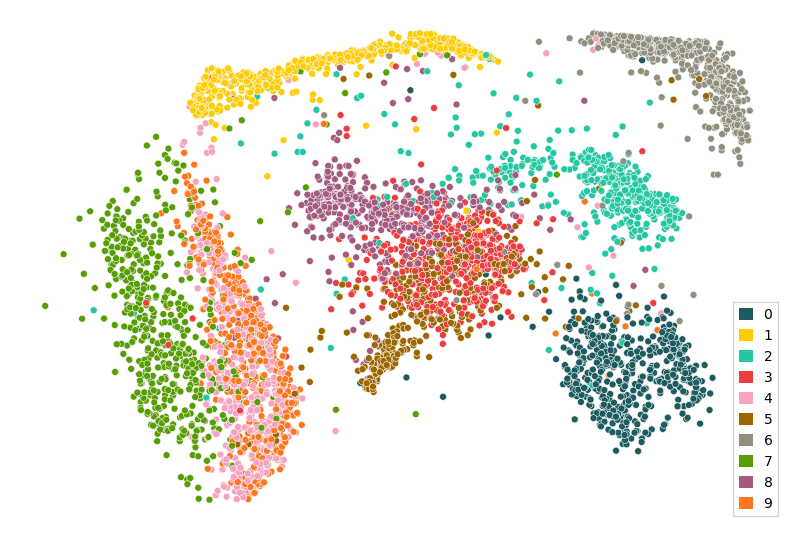

In [12]:
reduced = pumap.apply(mnist_data[:num_items])
pdutils.plotting.scatterplot(reduced, mnist.targets[:num_items])

Of course we can also apply our parametric UMAP to the whole MNIST data, without having to retrain it:

Once the training is complete, we can apply our parametric UMAP to the training data:

<AxesSubplot:>

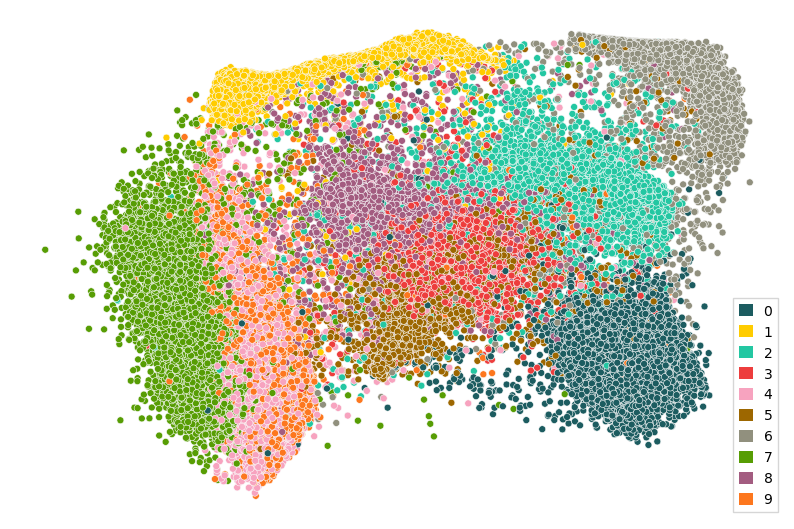

In [13]:
pdutils.plotting.scatterplot(pumap.apply(mnist_data), mnist.targets)

If you want to learn more about the individual steps, you can find more details in the section about the [Building Blocks of a paraDime Model](../building_blocks.rst) or in the [API Reference](../api/index.rst).